In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from steams.data import KVyQVx
from steams.models.attention import dpnn4
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 0
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = dpnn4(input_k=2,input_q=2, input_v=1, hidden_size=32)

In [11]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [12]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=20,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  1.006192  1.000691
  epoch   train     valid
0     1  0.9977  0.995824
  epoch     train     valid
0     2  0.997295  1.003598
  epoch     train     valid
0     3  1.005179  0.999713
  epoch     train     valid
0     4  0.968621  0.888137
  epoch     train     valid
0     5  0.854169  0.772821
  epoch     train     valid
0     6  0.787349  0.702702
  epoch     train     valid
0     7  0.702447  0.623869
  epoch     train     valid
0     8  0.682171  0.615324
  epoch     train    valid
0     9  0.676308  0.62632
  epoch     train     valid
0    10  0.662782  0.599121
  epoch     train     valid
0    11  0.647997  0.571161
  epoch     train     valid
0    12  0.640239  0.568559
  epoch     train     valid
0    13  0.631327  0.570517
  epoch     train     valid
0    14  0.631812  0.566626
  epoch     train     valid
0    15  0.627902  0.571511
  epoch     train    valid
0    16  0.626955  0.55847
  epoch     train    valid
0    17  0.622435  0.56615
  

In [13]:
obj.save_model(resdir,"1d-dpnn4")

## Evaluation

In [16]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [17]:
criterion = R2()
#criterion = torch.nn.MSELoss()
obj.init_criterion(criterion)

In [18]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

-1.0767925083637238


In [20]:
criterion = RMSE()
obj.init_criterion(criterion)

In [21]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.36914797127246857


In [22]:
criterion = variance()
obj.init_criterion(criterion)

In [23]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.06914551556110382


## QQplot

In [24]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [25]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


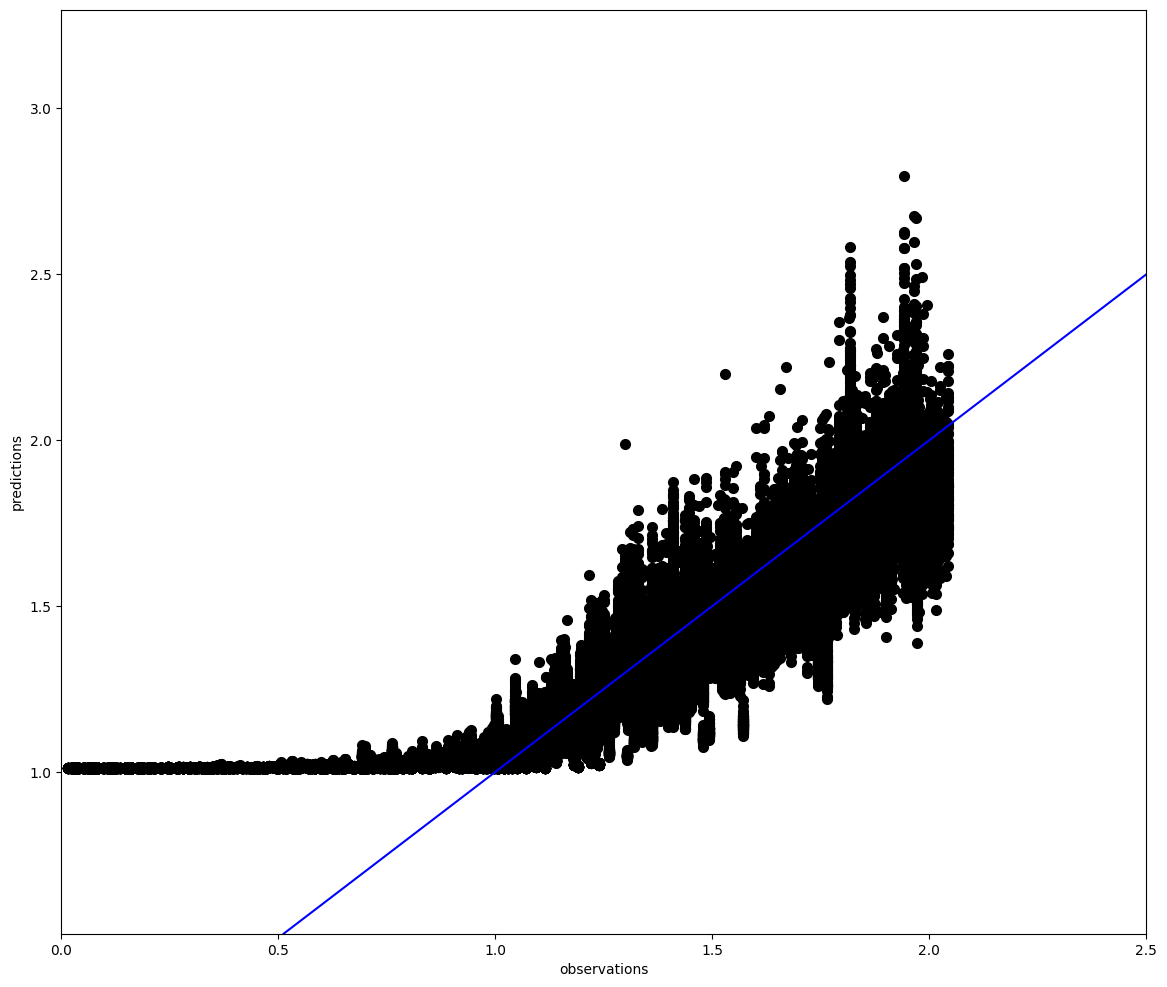

In [26]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1d-qqplot.png')
plt.savefig(fig_filename, dpi = 300)